# Conditional WGAN-GP

Created by Paul Scott<br>
MSE Computer and Information Science<br>
University of Pennsylvania<br>

# References
* https://keras.io/examples/generative/wgan_gp/
* https://keras.io/examples/generative/conditional_gan/
* https://www.tensorflow.org/tutorials/generative/dcgan

# Setup

### Install Clean FID
(runtime restart needed)

In [ ]:
%pip install clean-fid

### Imports

In [1]:
import os
import glob
import time
import shutil
import imageio

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from cleanfid import fid
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, optimizers

# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
noise_dim, num_classes = 0, 0

### Helper Functions

In [2]:
def generate_noise(count, class_labels=[], class_index=None):
  noise = tf.random.normal((count, noise_dim))
  if len(class_labels) > 0:
    noise_classes = class_labels
  elif class_index != None:
    noise_classes = tf.one_hot([class_index] * count, num_classes)
  else:
    noise_classes = tf.one_hot(np.random.randint(0, num_classes, size=count), num_classes)
  noise_classes = tf.reshape(noise_classes, (-1, num_classes))
  noise_with_classes = tf.concat((noise, noise_classes), axis=1)
  return noise_with_classes, noise_classes


def display_image_grid(images, labels=None, title=None):
  fig = plt.figure(figsize=(12, 12))
  if title:
    fig.suptitle(title, fontsize=16)
  for i in range(len(images)):
    grid_size = int(np.ceil(np.sqrt(len(images))))
    fig.add_subplot(grid_size, grid_size, i + 1)
    if labels:
      plt.title(labels[i][:14])
    plt.imshow(images[i] * 0.5 + 0.5)
    plt.axis('off')


def make_dir(directory):
  if not os.path.isdir(directory):
    os.makedirs(directory)


def remove_dir(directory):
  if os.path.isdir(directory):
    shutil.rmtree(directory)

# Preprocessing

### Load and Standardize Dataset

In [10]:
dataset_name = 'fairface'
dataset_dir = f'input_images/{dataset_name}'

batch_size = 16
img_dim = 128
channels = 3
img_shape = (img_dim, img_dim, channels)

datagen = preprocessing.image.ImageDataGenerator(
  preprocessing_function=lambda x: (x - 127.5) / 127.5,
)

dataset = datagen.flow_from_directory(
  dataset_dir,
  target_size=(img_dim, img_dim),
  batch_size=batch_size,
)

labels = list(dataset.class_indices.keys())
num_classes = len(labels)
img_shape_with_class = (img_dim, img_dim, channels + num_classes)

Found 86744 images belonging to 1 classes.


### Display Images from Dataset

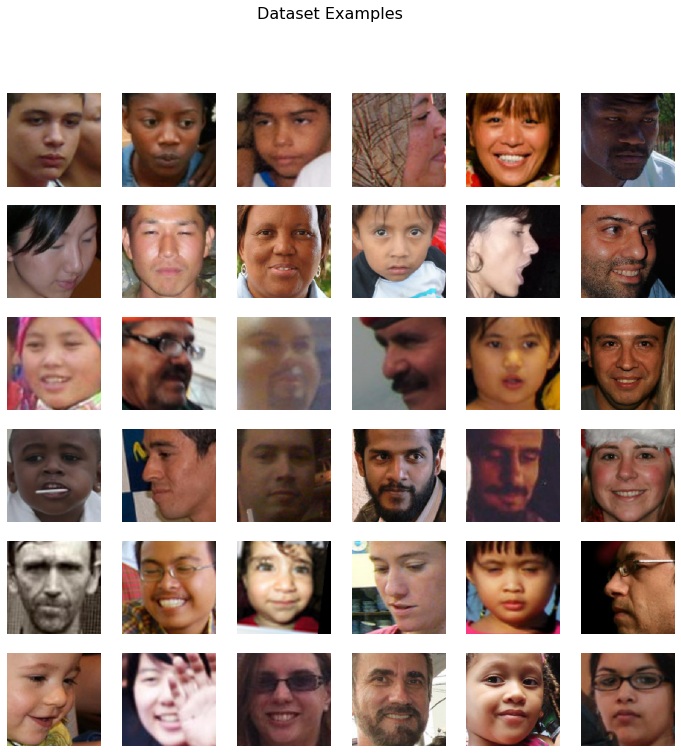

In [11]:
num_examples = 36

images, example_labels = [], []
while len(images) < num_examples:
  image_batch, label_batch = dataset.next()
  images += list(image_batch)
  example_labels += list(np.argmax(label_batch, axis=1))

images = images[:num_examples]
example_labels = [labels[i] for i in example_labels[:num_examples]]
example_labels = None if num_classes == 1 else example_labels

display_image_grid(images, example_labels, 'Dataset Examples')

# Create WGAN-GP

### Create Generator

In [12]:
noise_dim = 512

def generator_block(filters, first_layer):
  filters = min(filters, 512)
  if first_layer:
    block_layers = [layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=4, use_bias=False)]
  else:
    block_layers = [
      layers.UpSampling2D(),
      layers.Conv2D(filters=filters, kernel_size=3, padding='same', use_bias=False),
    ]
  block_layers += [
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(filters=filters, kernel_size=3, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
  ]
  return block_layers

filters = 2 ** (np.log2(img_dim) + 2)
min_filters = 16
first_layer = True
generator_layers = [layers.Reshape(target_shape=(1, 1, noise_dim + num_classes), input_shape=(noise_dim + num_classes,))]
while filters >= min_filters:
  generator_layers += generator_block(filters, first_layer)
  first_layer = False
  filters //= 2
generator_layers.append(layers.Conv2D(filters=3, kernel_size=1, padding='same', use_bias=False, activation='tanh'))

generator = models.Sequential(generator_layers)
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 1, 513)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4, 4, 512)        4202496   
 ranspose)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 4, 4, 512)         2359296   
                                                                 
 batch_normalization_13 (Bat  (None, 4, 4, 512)       

### Create Critic
(similar to discriminator in DCGANs)

In [13]:
def critic_block(filters, last_layer):
  filters = min(filters, 512)
  block_layers = [
    layers.Conv2D(filters=filters, kernel_size=3, padding='same', use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Conv2D(
      filters=min(filters*2, 512) if not last_layer else noise_dim,
      kernel_size=3 if not last_layer else 4,
      strides=1 if not last_layer else 4,
      padding='same' if not last_layer else 'valid',
      use_bias=False,
    ),
    layers.LeakyReLU(0.2),
  ]
  if not last_layer:
    block_layers.append(layers.MaxPool2D())
  return block_layers

filters = 16
max_filters = 2 ** (np.log2(img_dim) + 2)
critic_layers = [
 layers.Conv2D(filters=16, kernel_size=1, padding='same', use_bias=False, input_shape=img_shape_with_class),
 layers.LeakyReLU(0.2), 
]
while filters <= max_filters:
  critic_layers += critic_block(filters, filters == max_filters)
  first_layer = False
  filters *= 2
critic_layers += [
  layers.Flatten(),
  layers.Dense(1),
]

critic = models.Sequential(critic_layers)
critic.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 128, 128, 16)      64        
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 16)      2304      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_39 (Conv2D)          (None, 128, 128, 32)      4608      
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 32)      

# Training

### Wasserstein Gradient Penalty Loss

$L_C=\mathbb{E}[C(G(z))]-\mathbb{E}[C(x)]+\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$

$L_G=-\mathbb{E}[C(G(z))]$

Where:

* $C$ is the critic

* $G$ is the generator

* $x$ is sampled from the distribution of real images

* $z$ is random noise such that $z\sim\mathcal{N}(0,1)$

* $i$ is an interpolation between real and fake images defined as $i=\alpha x-(1-\alpha)G(z)$ where $\alpha\sim\mathcal{U}(0,1)$

* $C(x)$ is the critic's score for an input real image $x$

* $G(z)$ is an image generated using noise $z$

* $C(G(z))$ is the critic's score for an input fake image $G(z)$

* $\lambda$ is the penalty amount hyperparameter (the code uses $\lambda=10$)

Loss Explanation:

* The critic is trying to minimize $L_C$, which is equivalent to maximizing $\mathbb{E}[C(x)]$ and minimizing $\mathbb{E}[C(G(z))]$. The critic is trying to give the real images higher scores than the fake images.

* The generator is trying to minimize $L_G$, which is equivalent to maximizing $\mathbb{E}[C(G(z))]$. The generator is trying to trick the critic into giving fake images high scores.

* A penalty $\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$ is added to the critic loss to keep the norm of the gradient close to 1

### Define Training Functions

In [14]:
num_examples = 36
save_freq = 5
fid_freq = 5
show_labels = False

# define directories
checkpoint_dir = f'checkpoints/{dataset_name}'
metrics_dir = f'metrics/{dataset_name}'
output_dir = f'output_images/{dataset_name}'

# init metrics lists and generate seeds for images shown at each epoch
generator_losses, critic_losses, fid_scores = [], [], []
seed, seed_labels = generate_noise(num_examples)

# calculate stats needed for FID score
if not fid.test_stats_exists(dataset_name, 'clean'):
  fid.make_custom_stats(dataset_name, dataset_dir)

# configure optimizers and checkpoints
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
critic_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
  generator_optimizer=generator_optimizer,
  critic_optimizer=critic_optimizer,
  generator=generator,
  critic=critic,
)

def train(dataset, epochs, restore_epoch=0):
  make_dir('seeds')
  np.save(f'seeds/{dataset_name}_seed.npy', seed)

  avg_time_per_epoch = 0
  for epoch in range(restore_epoch, epochs):
    start = time.time()
    should_save = (epoch + 1) % save_freq == 0
    should_calc_fid = (epoch + 1) % fid_freq == 0

    for i in range(len(dataset)):
      print(f'\rEpoch {epoch+1} Progress: {i+1}/{len(dataset)}', end='')
      image_batch, labels_batch = dataset.next()
      critic_loss = train_critic(image_batch, labels_batch)
      generator_loss = train_generator(labels_batch)

    generator_losses.append(generator_loss)
    critic_losses.append(critic_loss)

    make_dir(metrics_dir)

    if epoch == 0 or should_calc_fid:
      fid = calculate_fid_score()
      fid_scores.append(fid)
      np.save(f'{metrics_dir}/fid_scores.npy', fid_scores)
    elif epoch == restore_epoch:
      fid = calculate_fid_score()

    np.save(f'{metrics_dir}/generator_losses.npy', generator_losses)
    np.save(f'{metrics_dir}/critic_losses.npy', critic_losses)

    display.clear_output(wait=True)
    generate_and_save_images(epoch + 1)
    print(f'Generator Loss: {round(float(generator_loss), 3)} | Critic Loss: {round(float(critic_loss), 3)} | FID: {round(fid, 3)}')

    if should_save:
      checkpoint.save(file_prefix = checkpoint_prefix)

    avg_time_per_epoch = print_time(start, epoch, epochs, restore_epoch, avg_time_per_epoch)


def train_critic(real_images, real_labels):
  noise, _ = generate_noise(len(real_labels), class_labels=real_labels) # z
  with tf.GradientTape() as critic_tape:
    fake_images = generator(noise, training=True) # G(z)
    
    real_images = add_labels_to_images(real_images, real_labels)
    fake_images = add_labels_to_images(fake_images, real_labels)

    real_output = critic(real_images, training=True) # C(x)
    fake_output = critic(fake_images, training=True) # C(G(z))
    
    critic_loss_unpenalized = calculate_critic_loss(real_output, fake_output) # E[C(G(z))] - E[C(x)]
    penalty = calculate_gradient_penalty(real_images, fake_images) # E[(||∇C(i)||₂ - 1)²]
    critic_loss = critic_loss_unpenalized + 10.0 * penalty # E[C(G(z))] - E[C(x)] + λ * E[(||∇C(i)||₂ - 1)²]

  gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
  critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
  return critic_loss


def train_generator(real_labels):
  noise, _ = generate_noise(len(real_labels), class_labels=real_labels) # z
  with tf.GradientTape() as generator_tape:
    fake_images = generator(noise, training=True) # G(z)
    fake_images = add_labels_to_images(fake_images, real_labels)
    fake_output = critic(fake_images, training=True) # C(G(z))
    generator_loss = calculate_generator_loss(fake_output) # -E[C(G(z))]

  gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  return generator_loss


# E[C(G(z))] - E[C(x)]
def calculate_critic_loss(real_output, fake_output):
  return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)


# -E[C(G(z))]
def calculate_generator_loss(fake_output):
  return -tf.reduce_mean(fake_output)


# E[(||∇C(i)||₂ - 1)²]
def calculate_gradient_penalty(real_images, fake_images):
  alpha = tf.random.normal((len(real_images), 1, 1, 1))
  interpolated = alpha * real_images + (1 - alpha) * fake_images # i = α * x + (1 - α) * G(z)

  with tf.GradientTape() as penalty_tape:
    penalty_tape.watch(interpolated)
    interpolated_output = critic(interpolated, training=True)

  grads = penalty_tape.gradient(interpolated_output, [interpolated])[0] # ∇C(i)
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3))) # ||∇C(i)||₂
  penalty = tf.reduce_mean((norm - 1.0) ** 2) # E[(||∇C(i)||₂ - 1)²]
  return penalty


def calculate_fid_score():
  remove_dir('fid_images')
  make_dir('fid_images')
  max_images = min(10000, len(dataset) * batch_size)
  for batch_num in range(len(dataset)):
    generated = generator.predict(generate_noise(batch_size)[0])
    for i, image in enumerate(generated):
      print(f'\rGenerated Images For FID: {batch_num * batch_size + i + 1}/{max_images}', end='')
      image = Image.fromarray((image * 127.5 + 127.5).astype(np.uint8))
      image.save(f'fid_images/{batch_num * batch_size + i}.png')
      if batch_num * batch_size + i + 1 == max_images:
        break
    else:
      continue
    break
  print()
  return fid.compute_fid('fid_images', dataset_name=dataset_name, dataset_split='custom', num_workers=0)


def add_labels_to_images(images, labels):
  labels = tf.repeat(labels, (img_dim * img_dim), axis=1)
  labels = tf.reshape(labels, (-1, img_dim, img_dim, num_classes))
  return tf.concat((images, labels), axis=3)


def generate_and_save_images(epoch):
  make_dir(output_dir)
  predictions = generator(seed, training=False)
  generated_labels = [labels[np.argmax(logit)] for logit in seed_labels]
  generated_labels = None if num_classes == 1 or not show_labels else generated_labels
  display_image_grid(predictions, generated_labels, f'Generated Images at Epoch {epoch}')
  plt.savefig('{}/image_at_epoch_{:04d}.png'.format(output_dir, epoch))
  plt.show()


def print_time(epoch_start, epoch, total_epochs, restore_epoch, avg_time_per_epoch):
  time_for_epoch = time.time() - epoch_start
  epoch_adj = epoch - restore_epoch
  avg_time_per_epoch = (avg_time_per_epoch * epoch_adj + time_for_epoch) / (epoch_adj + 1)
  remaining_epochs = total_epochs - (epoch + 1)
  
  time_for_epoch_string = get_time_string(time_for_epoch)
  remaining_time_string = get_time_string(remaining_epochs * avg_time_per_epoch)

  print(f'Time For Epoch {epoch + 1}: {time_for_epoch_string}')
  print(f'Remaining Time: {remaining_time_string}')

  return avg_time_per_epoch


def get_time_string(total_seconds):
  hours = int(total_seconds // 3600)
  remainder = total_seconds % 3600
  minutes = int(remainder // 60)
  seconds = round(remainder % 60, 2)
  time_string = ''
  if hours > 0:
    time_string += f'{hours}h '
  if remainder >= 60:
    time_string += f'{minutes}m '
  time_string += f'{seconds}s'
  return time_string

### Load Checkpoint
(if necessary)

In [15]:
checkpoint_num = 4

save_freq = 5
fid_freq = 5

seed = np.load(f'seeds/{dataset_name}_seed.npy')
generator_losses = list(np.load(f'{metrics_dir}/generator_losses.npy'))
critic_losses = list(np.load(f'{metrics_dir}/critic_losses.npy'))
fid_scores = list(np.load(f'{metrics_dir}/fid_scores.npy'))

if checkpoint_num:
  generator_losses = generator_losses[:checkpoint_num * save_freq]
  critic_losses = critic_losses[:checkpoint_num * save_freq]
  fid_scores = fid_scores[:(checkpoint_num * save_freq) // fid_freq + 1]
  with open(f'{checkpoint_dir}/checkpoint', 'w') as ckpt:
    ckpt.write(
      f'''
      model_checkpoint_path: "ckpt-{checkpoint_num}"
      all_model_checkpoint_paths: "ckpt-{checkpoint_num}"
      '''
    )

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Train WGAN-GP

In [ ]:
train(dataset, 50)

### Plot Metrics

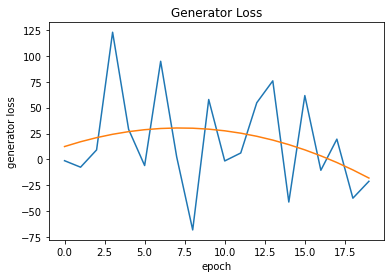

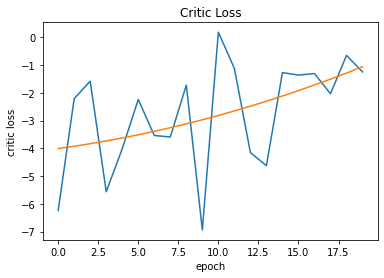

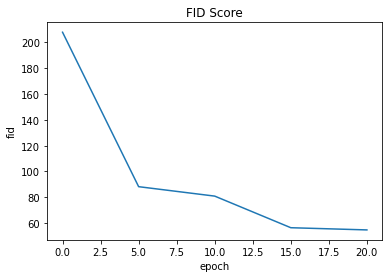

In [16]:
def get_poly_curve(y_values):
  x = np.arange(len(y_values))
  y = np.array(y_values)
  curve = np.polyfit(x, y, 2)
  poly_y = np.sum([a * x ** (2 - i) for i, a in enumerate(curve)], axis=0)
  return x, poly_y

# fit curves to losses
generator_curve_x, generator_curve_y = get_poly_curve(generator_losses)
critic_curve_x, critic_curve_y = get_poly_curve(critic_losses)

# plot generator loss
plt.plot(generator_losses)
plt.plot(generator_curve_x, generator_curve_y)
plt.title('Generator Loss')
plt.xlabel('epoch')
plt.ylabel('generator loss')
plt.show()

# plot critic loss
plt.plot(critic_losses)
plt.plot(critic_curve_x, critic_curve_y)
plt.title('Critic Loss')
plt.xlabel('epoch')
plt.ylabel('critic loss')
plt.show()

# plot fid scores
plt.plot(np.arange(0, len(fid_scores) * fid_freq, fid_freq), fid_scores)
plt.title('FID Score')
plt.xlabel('epoch')
plt.ylabel('fid')
plt.show()

### Save Generator

In [17]:
make_dir('saved_generators/')
models.save_model(generator, f'saved_generators/{dataset_name}')

INFO:tensorflow:Assets written to: saved_generators/fairface\assets


### Create GIF of Training Process

In [18]:
skip_size = 1
end_epoch = 20

with imageio.get_writer(f'gifs/{dataset_name}.gif', mode='I') as writer:
  filenames = sorted(glob.glob(f'output_images/{dataset_name}/image*.png'))
  for i in range(0, len(filenames), skip_size):
    if i == end_epoch:
      break
    writer.append_data(imageio.imread(filenames[i]))

# Results

### Load Generator

In [20]:
generator = models.load_model(f'saved_generators/{dataset_name}')

### Generate Images

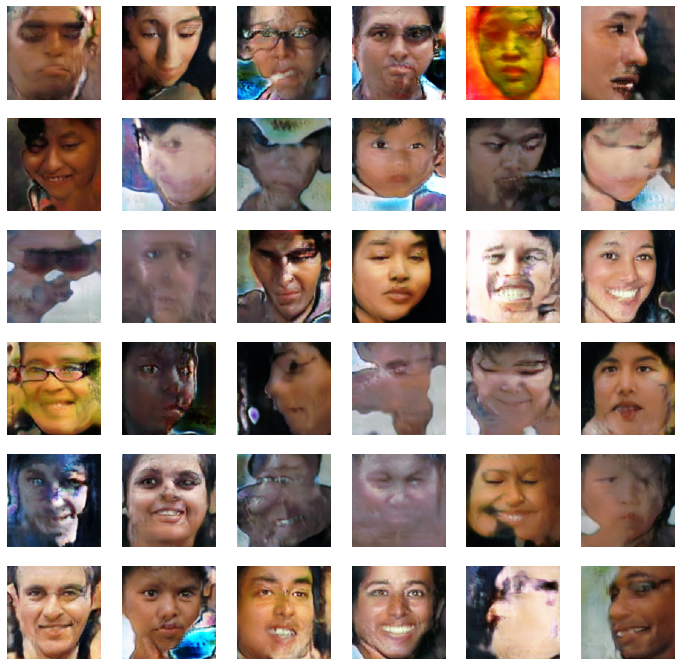

In [19]:
num_examples = 36
class_index = None

noise, noise_labels = generate_noise(num_examples, class_index=class_index)
noise_labels = [labels[np.argmax(label)] for label in noise_labels]
noise_labels = None if len(labels) == 1 else noise_labels
generated = generator(noise)
display_image_grid(generated, noise_labels)

### Explore latent space

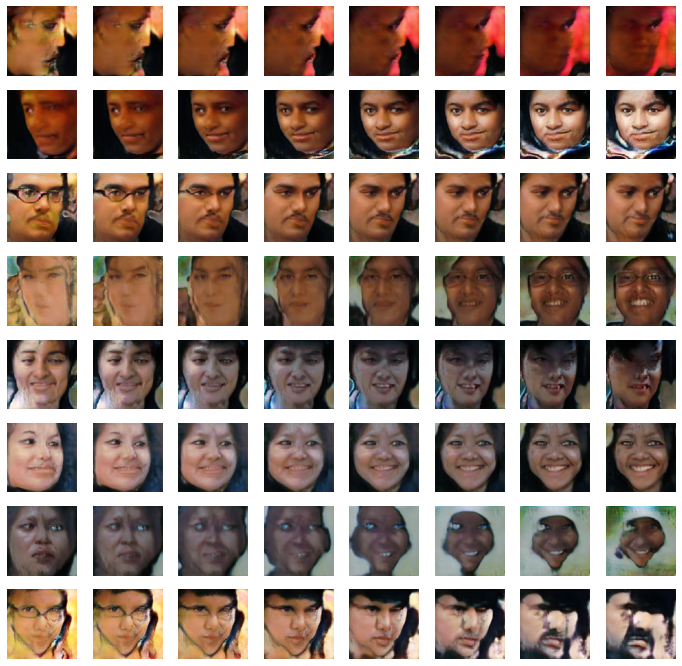

In [20]:
num_transitions = 7
num_examples = 8

fig = plt.figure(figsize=(12, 12))
for i in range(num_examples):
  classes = np.random.choice(np.arange(num_classes), size=2)
  start_noise = np.concatenate((np.random.normal(size=noise_dim), tf.one_hot(classes[0], num_classes))).reshape((1, noise_dim + num_classes))
  end_noise = np.concatenate((np.random.normal(size=noise_dim), tf.one_hot(classes[1], num_classes))).reshape((1, noise_dim + num_classes))
  for t in range(num_transitions + 1):
    step = t / (num_transitions + 1)
    noise = (1 - step) * start_noise + step * end_noise
    output = generator.predict(noise).reshape(img_shape)
    grid_size = int(np.ceil(np.sqrt(num_examples)))
    fig.add_subplot(num_transitions + 1, num_examples, i * (num_transitions + 1) + t + 1)
    plt.imshow(output * 0.5 + 0.5)
    plt.axis('off')